# Impact of computing on conventional businesses and markets

In this notebook we will analyze how computing impacted conventional businesses and markets.

Transistor information was extracted from [wikipedia transistor count](https://en.wikipedia.org/wiki/Transistor_count) using [wikitable2csv.ggor.de](https://wikitable2csv.ggor.de/) to extract the tables

US 2001-2020 real state sales dataset was obtained from [data.gov](https://catalog.data.gov/dataset/real-estate-sales-2001-2018)

Households with broadband access dataset was obtained from [data.aecd.ord](https://data.oecd.org/broadband/households-with-broadband-access.htm)


### Dependencies

In [178]:
# Standard packages
import pandas as pd
import numpy as np
import re

# Installed packages
from IPython.display import display
from matplotlib import pyplot as plt
%pip install seaborn
import seaborn as sns
%pip install statsmodels
import statsmodels.api as sm
%pip install pingouin
import pingouin as pg

# Local packages
# NOTE: avoid having to use a local module to ease use of Google Colab

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Globals and constants

In [179]:
# Constants
DATE_COLUMN = 'Year'
MIN_YEAR = 2001
MAX_YEAR = 2020
DATASETS_FOLDER = './content'
SAVE_CLEANED_DATA = False

# Global state
final_dataframes = []

### Cleaning and reviewing Computing Advances

In [180]:
def keep_columns(df:pd.DataFrame, columns:list) -> pd.DataFrame:
    """Keep only the specified columns"""
    return df[columns]

def date_to_year(df:pd.DataFrame, date_column:str) -> pd.DataFrame:
    """Convert DATE_COLUMN to year and rename column to 'Year'"""
    #
    year_pattern = r'\d{4}'
    df = df.astype({date_column: str})
    df = df[df[date_column].str.contains(year_pattern)]
    df[date_column] = df[date_column].apply(lambda x: re.findall(year_pattern, x)[0])
    #
    if date_column != DATE_COLUMN:
        df = df.rename(columns={date_column: DATE_COLUMN})
    return df

def remove_commas(df:pd.DataFrame) -> pd.DataFrame:
    """Remove commas from all columns"""
    return df.apply(lambda x: x.str.replace(',', ''))

def convert_to_float(df:pd.DataFrame, columns:list) -> pd.DataFrame:
    """Convert the specified columns to float"""
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def cut_add_years(
        df: pd.DataFrame,
        year_column:str=DATE_COLUMN,
        min_year:int=MIN_YEAR,
        max_year:int=MAX_YEAR
        ) -> pd.DataFrame:
    """Cut the dataframe to the specified years and add missing years"""
    # Ensure integer type
    df[year_column] = df[year_column].astype(int)
    # Add missing years
    for year in range(min_year, max_year):
        if year not in df[year_column].values:
            df = pd.concat([df, pd.DataFrame.from_records([{ year_column: year }])])
    df = df.sort_values(by=[year_column]).reset_index(drop=True)
    # Cut years
    df = df[(df[year_column] >= min_year) & (df[year_column] <= max_year)]
    return df

def keep_highest_per_year(
        df: pd.DataFrame,
        value_column:str, 
        year_column:str=DATE_COLUMN
        ) -> pd.DataFrame:
    """Keep only the highest value for each year, useful when we want only the
       advance of a technology, so we don't care about the lower values"""
    df = df.sort_values(by=[year_column, value_column], ascending=False)
    df = df.drop_duplicates(subset=[year_column], keep='first')
    # Back to the original order
    df = df.sort_values(by=[year_column]).reset_index(drop=True)
    return df

def year_column_to_row(df:pd.DataFrame, country_row:str, new_column_name:str) -> pd.DataFrame:
    """Converts columns to rows and filters by country, useful for the world bank data datasets"""
    # Filter rows by country
    df = df[df['Country Name'] == country_row]
    # Remove columns that are not a year
    df = df[df.columns[df.columns.str.contains(r'\d{4}')]]
    # Convert columns to rows
    df = df.melt(id_vars=[], var_name=DATE_COLUMN, value_name=new_column_name)
    return df

Flash memory

# Original data


,Chip name,Capacity (bits),Flash type,FGMOS transistor count,Date of introduction,Manufacturer(s),Process,Area,"Transistor density, tr./mm2",Ref
19,KLMCG8GE4A,512 Gb,Stacked 2-bit NAND,"256,000,000,000",2011,Samsung,?,192 mm2,"1,333,000,000",NaN
20,KLUFG8R1EM,4 Tb,Stacked 3-bit V-NAND,"1,365,333,333,504",2017,Samsung,?,150 mm2,"9,102,000,000",NaN
21,eUFS (1 TB),8 Tb,Stacked 4-bit V-NAND,"2,048,000,000,000",2019,Samsung,?,150 mm2,"13,650,000,000",NaN
22,?,1 Tb,232L TLC NAND die,"333,333,333,333",2022,Micron,?,68.5 mm2 (memory array),"4,870,000,000 (14.6 Gbit/mm2)",NaN
23,?,16 Tb,232L package,"5,333,333,333,333",2022,Micron,?,68.5 mm2 (memory array),"77,900,000,000 (16× 14.6 Gbit/mm2)",NaN


# Cleaned data


,FGMOS transistor count,Year
15,2.560000e+11,2015
16,2.560000e+11,2016
17,1.365333e+12,2017
18,1.365333e+12,2018
19,2.048000e+12,2019


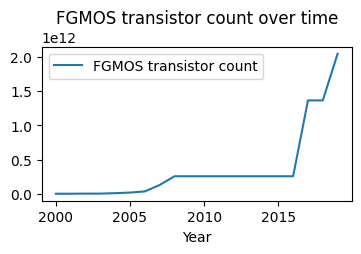

In [181]:
flash = pd.read_csv(f'{DATASETS_FOLDER}/flash.csv')
#
print('# Original data')
display(flash.tail())
#
flash = keep_columns(flash, ['FGMOS transistor count', 'Date of introduction'])
flash = date_to_year(flash, 'Date of introduction')
flash = remove_commas(flash)
flash = convert_to_float(flash, ['FGMOS transistor count'])
flash = cut_add_years(flash)
flash = keep_highest_per_year(flash, 'FGMOS transistor count')
flash = flash.fillna(method='ffill')
final_dataframes.append(flash)
#
print('# Cleaned data')
display(flash.tail())
flash.plot(x=DATE_COLUMN, y='FGMOS transistor count', title='FGMOS transistor count over time', figsize=(4, 2))
plt.show()

FPGA

# Original data


,FPGA,Transistor count,Date of introduction,Designer,Manufacturer,Process,Area,"Transistor density, tr./mm2",Ref
11,Virtex-Ultrascale VU440,"20,000,000,000",Q1 2015,Xilinx,TSMC,20 nm,NaN,NaN,NaN
12,Virtex-Ultrascale+ VU19P,"35,000,000,000",2020,Xilinx,TSMC,16 nm,900 mm2,"38,900,000",NaN
13,Versal VC1902,"37,000,000,000",2H 2019,Xilinx,TSMC,7 nm,NaN,NaN,NaN
14,Stratix 10 GX 10M,"43,300,000,000",Q4 2019,Intel,Intel,14 nm,"1,400 mm2","30,930,000",NaN
15,Versal VP1802,"92,000,000,000",2021 ?,Xilinx,TSMC,7 nm,NaN,NaN,NaN


# Cleaned data


,FPGA transistor count,Year
16,2.000000e+10,2016
17,2.000000e+10,2017
18,2.000000e+10,2018
19,4.330000e+10,2019
20,3.500000e+10,2020


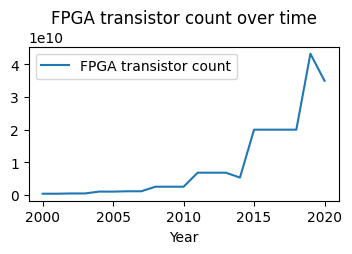

In [182]:
fpga = pd.read_csv(f'{DATASETS_FOLDER}/fpga.csv')
#
print('# Original data')
display(fpga.tail())
#
fpga = keep_columns(fpga, ['Transistor count', 'Date of introduction'])
fpga = date_to_year(fpga, 'Date of introduction')
fpga = remove_commas(fpga)
fpga = convert_to_float(fpga, ['Transistor count'])
fpga = cut_add_years(fpga)
fpga = fpga.rename(columns={'Transistor count': 'FPGA transistor count'})
fpga = keep_highest_per_year(fpga, 'FPGA transistor count')
fpga = fpga.fillna(method='ffill')
final_dataframes.append(fpga)
#
print('# Cleaned data')
display(fpga.tail())
fpga.plot(x=DATE_COLUMN, y='FPGA transistor count', title='FPGA transistor count over time', figsize=(4, 2))
plt.show()

GPU

# Original data


,Processor,Transistor count,Year,Designer(s),Fab(s),Process,Area,"Transistor density, tr./mm2",Ref
158,AD102 Ada Lovelace,"76,300,000,000",2022,Nvidia,TSMC,4 nm,608.4 mm²,"125,411,000",NaN
159,AD103 Ada Lovelace,"45,900,000,000",2022,Nvidia,TSMC,4 nm,378.6 mm²,"121,240,000",NaN
160,AD104 Ada Lovelace,"35,800,000,000",2022,Nvidia,TSMC,4 nm,294.5 mm²,"121,560,000",NaN
161,Navi 31 RDNA3,"58,000,000,000",2022,AMD,TSMC,5 nm (GCD) 6 nm (MCD),531 mm² (MCM) 306 mm² (GCD) 6×37.5 mm² (MCD),"109,200,000 (MCM) 132,400,000 (GCD)",NaN
162,Navi 33 RDNA3,"13,300,000,000",2023,AMD,TSMC,6 nm,204 mm²,"65,200,000",NaN


# Cleaned data


,GPU transistor count,Year
16,1.530000e+10,2016
17,2.110000e+10,2017
18,1.860000e+10,2018
19,1.030000e+10,2019
20,5.420000e+10,2020


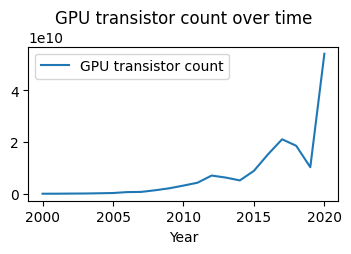

In [183]:
gpus = pd.read_csv(f'{DATASETS_FOLDER}/gpus.csv')
#
print('# Original data')
display(gpus.tail())
#
gpus = keep_columns(gpus, ['Transistor count', 'Year'])
gpus = date_to_year(gpus, 'Year')
gpus = remove_commas(gpus)
gpus = convert_to_float(gpus, ['Transistor count'])
gpus = cut_add_years(gpus)
gpus = gpus.rename(columns={'Transistor count': 'GPU transistor count'})
gpus = keep_highest_per_year(gpus, 'GPU transistor count')
gpus = gpus.fillna(method='ffill')
final_dataframes.append(gpus)
#
print('# Cleaned data')
display(gpus.tail())
gpus.plot(x='Year', y='GPU transistor count', title='GPU transistor count over time', figsize=(4, 2))
plt.show()

Microprocessor

# Original data


,Processor,Transistor count,Year,Designer,Process\n(nm),Area (mm2),"Transistor density, tr./mm2"
229,AMD EPYC Genoa (4th gen/9004 series) 13-chip m...,"90,000,000,000",2022,AMD,5 nm (CCD)\n6 nm (IOD),"1,263.34 mm²\n12×72.225 (CCD)\n396.64 (IOD)","71,240,000"
230,Sapphire Rapids quad-chip module (up to 60 cor...,"44,000,000,000–48,000,000,000",2023,Intel,Intel 7 (10 nm ESF),"1,600 mm2","27,500,000–\n30,000,000"
231,"Apple M2 Pro (12-core 64-bit ARM64 SoC, SIMD, ...","40,000,000,000",2023,Apple,5 nm,?,?
232,"Apple M2 Max (12-core 64-bit ARM64 SoC, SIMD, ...","67,000,000,000",2023,Apple,5 nm,?,?
233,Processor,Transistor count,Year,Designer,Process\n(nm),Area (mm2),"Transistor density, tr./mm2"


# Cleaned data


,Microprocessor transistor count,Year
16,8000000000,2016
17,19200000000,2017
18,10000000000,2018
19,39540000000,2019
20,16000000000,2020


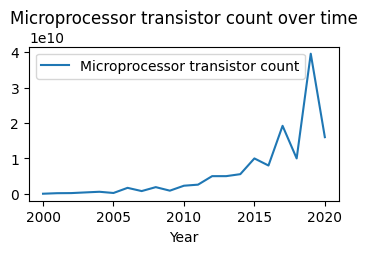

In [184]:
microprocessors = pd.read_csv(f'{DATASETS_FOLDER}/microprocessors.csv')
#
print('# Original data')
display(microprocessors.tail())
#
microprocessors = keep_columns(microprocessors, ['Transistor count', 'Year'])
microprocessors = date_to_year(microprocessors, 'Year')
microprocessors = remove_commas(microprocessors)
microprocessors = microprocessors[microprocessors['Transistor count'].str.contains(r'^\d+$')]
microprocessors = convert_to_float(microprocessors, ['Transistor count'])
microprocessors = microprocessors.rename(columns={'Transistor count': 'Microprocessor transistor count'})
microprocessors = cut_add_years(microprocessors)
microprocessors = keep_highest_per_year(microprocessors, 'Microprocessor transistor count')
microprocessors = microprocessors.fillna(method='ffill')
final_dataframes.append(microprocessors)
#
print('# Cleaned data')
display(microprocessors.tail())
microprocessors.plot(x='Year', y='Microprocessor transistor count', title='Microprocessor transistor count over time', figsize=(4, 2))
plt.show()


RAM

Note that we will drop this dataset because contains a lot of NaN values

# Original data


,Chip name,Capacity (bits),RAM type,Transistor count,Date of introduction,Manufacturer(s),Process,Area,"Transistor density, tr./mm2",Ref
43,?,16 Gb,SDRAM (DDR3),"17,179,869,184",2008,Samsung,50 nm,?,?,NaN
44,?,32 Gb,SDRAM (HBM2),"34,359,738,368",2016,Samsung,20 nm,?,?,NaN
45,?,64 Gb,SDRAM (HBM2),"68,719,476,736",2017,Samsung,20 nm,?,?,NaN
46,?,128 Gb,SDRAM (DDR4),"137,438,953,472",2018,Samsung,10 nm,?,?,NaN
47,?,?,RRAM (3DSoC),?,2019,SkyWater Technology,90 nm,?,?,NaN


# Cleaned data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  20 non-null     int64  
 1   RAM transistor count  12 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 448.0 bytes


None

,Year,RAM transistor count
15,2015,1.717987e+10
16,2016,3.435974e+10
17,2017,6.871948e+10
18,2018,1.374390e+11
19,2019,1.374390e+11


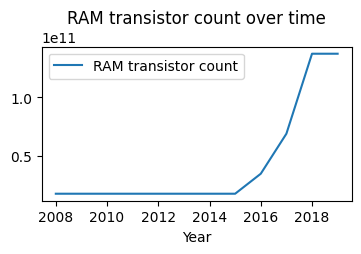

In [185]:
ram = pd.read_csv(f'{DATASETS_FOLDER}/ram.csv')
#
print('# Original data')
display(ram.tail())
#
ram = keep_columns(ram, ['Date of introduction', 'Transistor count'])
ram = date_to_year(ram, 'Date of introduction')
ram = remove_commas(ram)
ram = convert_to_float(ram, ['Transistor count'])
ram = ram.rename(columns={'Transistor count': 'RAM transistor count'})
ram = cut_add_years(ram)
ram = keep_highest_per_year(ram, 'RAM transistor count')
ram = ram.fillna(method='ffill')
# BAD: final_dataframes.append(ram) this dataset has a lot of Nan values
# show
print('# Cleaned data')
display(ram.info())
display(ram.tail())
ram.plot(x='Year', y='RAM transistor count', title='RAM transistor count over time', figsize=(4, 2))
plt.show()

ROM

Note that we will drop this data since this lack of data from 2000s up to now

# Original data


,Chip name,Capacity (bits),ROM type,Transistor count,Date of introduction,Manufacturer(s),Process,Area,Ref
17,27512,512 Kb,EPROM (HMOS),"524,288",1984,Intel,?,?,NaN
18,?,1 Mb,EPROM (CMOS),"1,048,576",1984,NEC,"1,200 nm",?,NaN
19,?,4 Mb,EPROM (CMOS),"4,194,304",1987,Toshiba,800 nm,?,NaN
20,?,16 Mb,EPROM (CMOS),"16,777,216",1990,NEC,600 nm,?,NaN
21,?,16 Mb,MROM,"16,777,216",1995,"AKM, Hitachi",?,?,NaN


# Cleaned data


,Year,ROM transistor count
15,2015,NaN
16,2016,NaN
17,2017,NaN
18,2018,NaN
19,2019,NaN


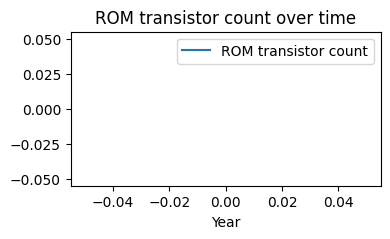

In [186]:
rom = pd.read_csv(f'{DATASETS_FOLDER}/rom.csv')
#
print('# Original data')
display(rom.tail())
#
rom = keep_columns(rom, ['Date of introduction', 'Transistor count'])
rom = date_to_year(rom, 'Date of introduction')
rom = remove_commas(rom)
rom = convert_to_float(rom, ['Transistor count'])
rom = rom.rename(columns={'Transistor count': 'ROM transistor count'})
rom = cut_add_years(rom)
rom = keep_highest_per_year(rom, 'ROM transistor count')
rom = rom.fillna(method='ffill')
# BAD: final_dataframes.append(rom) this lacks data from 2000 up to now
# show
print('# Cleaned data')
display(rom.tail())
rom.plot(x='Year', y='ROM transistor count', title='ROM transistor count over time', figsize=(4, 2))
plt.show()

Internet

# Original data


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
261,Kosovo,XKX,Individuals using the Internet (% of population),IT.NET.USER.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,83.893597,89.443032,NaN,NaN,NaN,NaN,NaN
262,"Yemen, Rep.",YEM,Individuals using the Internet (% of population),IT.NET.USER.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,22.55000,24.085409,24.579208,26.718355,NaN,NaN,NaN,NaN,NaN,NaN
263,South Africa,ZAF,Individuals using the Internet (% of population),IT.NET.USER.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,49.00000,51.919116,54.000000,56.167394,62.400000,69.696875,70.320310,72.310492,NaN,NaN
264,Zambia,ZMB,Individuals using the Internet (% of population),IT.NET.USER.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,6.50000,8.800000,10.300000,12.200000,14.299997,16.800000,18.051915,21.231531,NaN,NaN
265,Zimbabwe,ZWE,Individuals using the Internet (% of population),IT.NET.USER.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,16.36474,22.742818,23.119989,24.400000,25.000000,26.588274,29.298565,34.813971,NaN,NaN


# Cleaned data


,Year,US internet percentage
56,2016,85.544421
57,2017,87.274889
58,2018,88.498903
59,2019,89.430285
60,2020,90.620470


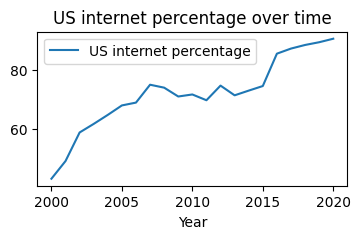

In [187]:
internet = pd.read_csv(f'{DATASETS_FOLDER}/theworldbank_internet.csv')
#
print('# Original data')
display(internet.tail())
#
internet = year_column_to_row(internet, 'United States', 'US internet percentage')
internet = cut_add_years(internet)
final_dataframes.append(internet)
#
print('# Cleaned data')
display(internet.tail())
internet.plot(x='Year', y='US internet percentage', title='US internet percentage over time', figsize=(4, 2))
plt.show()

In [188]:
## TODO: add phones related data

In [189]:
## TODO: add AI related data

In [190]:
## TODO: add SSD related data

### Cleaning and reviewing the United States economy data

GDP

# Original data


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
261,Kosovo,XKX,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,6.735731e+09,7.074658e+09,6.295820e+09,6.682833e+09,7.180813e+09,7.878509e+09,7.899879e+09,7.716925e+09,9.412034e+09,NaN
262,"Yemen, Rep.",YEM,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4.041523e+10,4.322859e+10,4.244450e+10,3.131783e+10,2.684223e+10,2.160616e+10,NaN,NaN,NaN,NaN
263,South Africa,ZAF,GDP (current US$),NY.GDP.MKTP.CD,8.748597e+09,9.225996e+09,9.813996e+09,1.085420e+10,1.195600e+10,1.306899e+10,...,4.008860e+11,3.811989e+11,3.467098e+11,3.235855e+11,3.814488e+11,4.041597e+11,3.885320e+11,3.376197e+11,4.190150e+11,NaN
264,Zambia,ZMB,GDP (current US$),NY.GDP.MKTP.CD,7.130000e+08,6.962857e+08,6.931429e+08,7.187143e+08,8.394286e+08,1.082857e+09,...,2.803724e+10,2.714102e+10,2.125122e+10,2.095841e+10,2.587360e+10,2.631159e+10,2.330867e+10,1.811063e+10,2.214763e+10,NaN
265,Zimbabwe,ZWE,GDP (current US$),NY.GDP.MKTP.CD,1.052990e+09,1.096647e+09,1.117602e+09,1.159512e+09,1.217138e+09,1.311436e+09,...,1.909102e+10,1.949552e+10,1.996312e+10,2.054868e+10,1.758489e+10,3.415607e+10,2.183223e+10,2.150970e+10,2.837124e+10,NaN


# Cleaned data


,Year,US GDP
56,2016,1.869511e+13
57,2017,1.947734e+13
58,2018,2.053306e+13
59,2019,2.138098e+13
60,2020,2.106047e+13


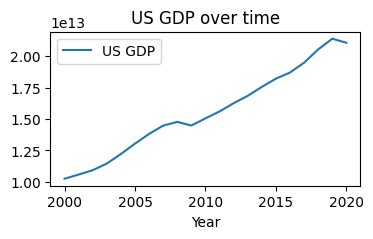

In [191]:
gdp = pd.read_csv(f'{DATASETS_FOLDER}/theworldbank_gdp.csv')
#
print('# Original data')
display(gdp.tail())
#
gdp = year_column_to_row(gdp, 'United States', 'US GDP')
gdp = cut_add_years(gdp)
final_dataframes.append(gdp)
#
print('# Cleaned data')
display(gdp.tail())
gdp.plot(x='Year', y='US GDP', title='US GDP over time', figsize=(4, 2))
plt.show()

Population

# Original data


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
261,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,1818117.0,1812771.0,1788196.0,1777557.0,1791003.0,1797085.0,1788878.0,1790133.0,1786038.0,NaN
262,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5542459.0,5646668.0,5753386.0,5860197.0,5973803.0,6097298.0,...,26984002.0,27753304.0,28516545.0,29274002.0,30034389.0,30790513.0,31546691.0,32284046.0,32981641.0,NaN
263,South Africa,ZAF,"Population, total",SP.POP.TOTL,16520441.0,16989464.0,17503133.0,18042215.0,18603097.0,19187194.0,...,53873616.0,54729551.0,55876504.0,56422274.0,56641209.0,57339635.0,58087055.0,58801927.0,59392255.0,NaN
264,Zambia,ZMB,"Population, total",SP.POP.TOTL,3119430.0,3219451.0,3323427.0,3431381.0,3542764.0,3658024.0,...,15234976.0,15737793.0,16248230.0,16767761.0,17298054.0,17835893.0,18380477.0,18927715.0,19473125.0,NaN
265,Zimbabwe,ZWE,"Population, total",SP.POP.TOTL,3806310.0,3925952.0,4049778.0,4177931.0,4310332.0,4447149.0,...,13555422.0,13855753.0,14154937.0,14452704.0,14751101.0,15052184.0,15354608.0,15669666.0,15993524.0,NaN


# Cleaned data


,Year,US Population
56,2016,323071755.0
57,2017,325122128.0
58,2018,326838199.0
59,2019,328329953.0
60,2020,331501080.0


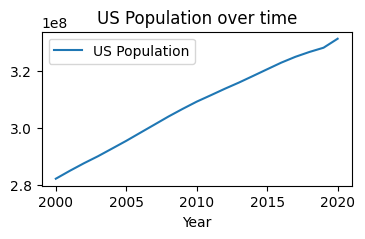

In [192]:
population = pd.read_csv(f'{DATASETS_FOLDER}/theworldbank_population.csv')
#
print('# Original data')
display(population.tail())
#
population = year_column_to_row(population, 'United States', 'US Population')
population = cut_add_years(population)
final_dataframes.append(population)
#
print('# Cleaned data')
display(population.tail())
population.plot(x='Year', y='US Population', title='US Population over time', figsize=(4, 2))
plt.show()

### Cleaning and reviewing real estate data

# Original data


/tmp/ipykernel_60625/298256170.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  real_estate_sales = pd.read_csv(f'{DATASETS_FOLDER}/real_estate_sales.csv')


,Date Recorded,Sale Amount,Property Type,Residential Type
997208,06/24/2020,53100.0,Single Family,Single Family
997209,11/27/2019,76000.0,Single Family,Single Family
997210,04/27/2020,210000.0,Single Family,Single Family
997211,06/03/2020,280000.0,Single Family,Single Family
997212,12/20/2019,7450000.0,NaN,NaN


# Cleaned data


,Year,Sale Amount,Property Type,Residential Type
997208,2020,53100.0,Single Family,Single Family
997209,2019,76000.0,Single Family,Single Family
997210,2020,210000.0,Single Family,Single Family
997211,2020,280000.0,Single Family,Single Family
997212,2019,7450000.0,NaN,NaN


Real estate properties types:
1.	Commercial
2.	Residential
3.	Vacant Land
4.	nan
5.	Apartments
6.	Industrial
7.	Public Utility
8.	Condo
9.	Two Family
10.	Three Family
11.	Single Family
12.	Four Family

Real estate residential types:
1.	nan
2.	Single Family
3.	Condo
4.	Two Family
5.	Three Family
6.	Four Family


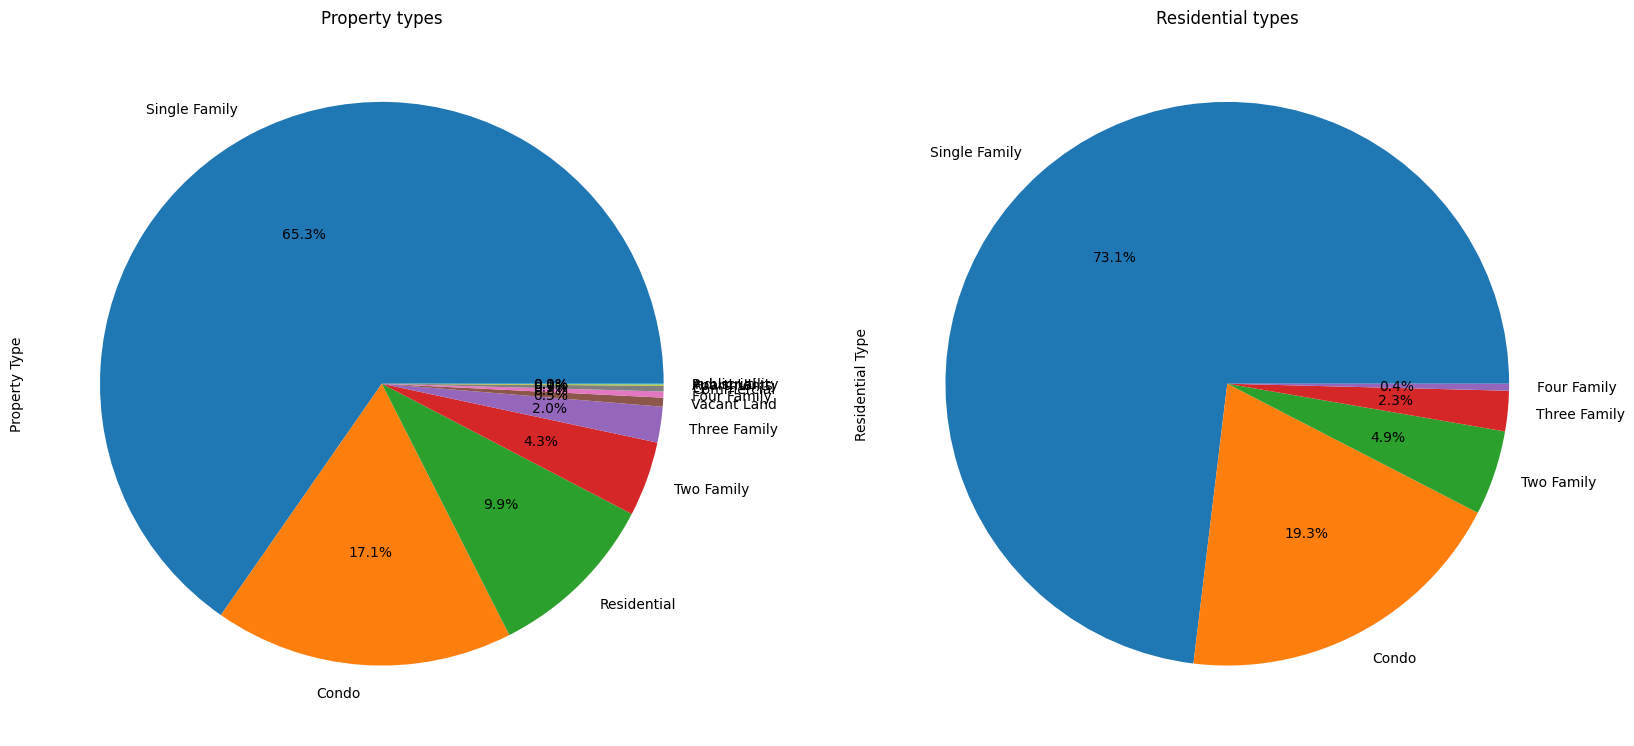

In [193]:
real_estate_sales = pd.read_csv(f'{DATASETS_FOLDER}/real_estate_sales.csv')
#
print('# Original data')
display(real_estate_sales.tail())
#
real_estate_sales = keep_columns(real_estate_sales, [
    'Date Recorded', 'Sale Amount', 'Property Type', 'Residential Type',
    ])
# Save cleaned data because github doesn't allow files larger than 100MB
if SAVE_CLEANED_DATA:
    real_estate_sales.to_csv(f'{DATASETS_FOLDER}/real_estate_sales.csv', index=False)
real_estate_sales = date_to_year(real_estate_sales, 'Date Recorded')
#
print('# Cleaned data')
display(real_estate_sales.tail())
# Plotting Property and Residential types
fig, axs = plt.subplots(1, 2, figsize=(20, 20))
real_estate_sales['Property Type'] \
    .value_counts(normalize=True).plot.pie(autopct='%1.1f%%', title='Property types', ax=axs[0])
real_estate_sales['Residential Type'] \
    .value_counts(normalize=True).plot.pie(autopct='%1.1f%%', title='Residential types', ax=axs[1])
# Show properties and residential types
def get_types(df:pd.DataFrame, column:str) -> list:
    types = df[column].unique()
    types = [str(x) for x in types]
    return types
def print_types(df: pd.DataFrame, column:str) -> None:
    types = get_types(df, column)
    for i, x in enumerate(types):
        print(f'{i+1}.\t{x}')
print('Real estate properties types:')
print_types(real_estate_sales, 'Property Type')
print()
print('Real estate residential types:')
print_types(real_estate_sales, 'Residential Type')

Grouping by year

In [194]:
# We will create a new dataframe with sales per year
real_estate_per_year = pd.DataFrame()

# Add year column
real_estate_per_year[DATE_COLUMN] = real_estate_sales[DATE_COLUMN].unique()
real_estate_per_year = real_estate_per_year.sort_values(by=[DATE_COLUMN]).reset_index(drop=True)

# Add sales per year (number or rows)
real_estate_per_year['US real estate total sales'] = real_estate_sales.groupby(DATE_COLUMN).size().values

# Add total money in sales per year
real_estate_per_year['US total real estate sales value'] = real_estate_sales.groupby(DATE_COLUMN)['Sale Amount'].sum().values

# Add a new column per property and residential type with sum of sales per year
def annual_sales_amount_per_type(df:pd.DataFrame, column_type_name:str) -> pd.DataFrame:
    result = pd.DataFrame()
    # Add year column
    result[DATE_COLUMN] = df[DATE_COLUMN].unique()
    result = result \
        .sort_values(by=[DATE_COLUMN]) \
        .reset_index(drop=True)
    # Add type sales per year
    for type in get_types(df, column_type_name):
        new_column_name = f'US real estate {column_type_name.lower()} {type.upper()} total sales amount'
        result[new_column_name] = np.nan
        for year in result[DATE_COLUMN]:
            # Get sales amount per year
            sales_amount = df[(df[column_type_name] == type) & (df[DATE_COLUMN] == year)]['Sale Amount'].sum()
            # Add sales amount to the new column for the current year
            result.loc[result[DATE_COLUMN] == year, new_column_name] = sales_amount
        # Fill NaN values with 0
        result[new_column_name] = result[new_column_name].fillna(0)
    return result
property_types_annual = annual_sales_amount_per_type(real_estate_sales, 'Property Type')
residential_types_annual = annual_sales_amount_per_type(real_estate_sales, 'Residential Type')

# Drop columns with lot of zeros.
property_types_annual = keep_columns(property_types_annual, [
    DATE_COLUMN,
    'US real estate property type CONDO total sales amount',
    'US real estate property type TWO FAMILY total sales amount',
    'US real estate property type THREE FAMILY total sales amount',
    'US real estate property type SINGLE FAMILY total sales amount',
    'US real estate property type FOUR FAMILY total sales amount',
])
residential_types_annual = keep_columns(residential_types_annual, [
    DATE_COLUMN,
    'US real estate residential type SINGLE FAMILY total sales amount',
    'US real estate residential type CONDO total sales amount',
    'US real estate residential type TWO FAMILY total sales amount',
    'US real estate residential type THREE FAMILY total sales amount',
    'US real estate residential type FOUR FAMILY total sales amount'
])

# Final real estate dataframe
print('# Real estate sales per year')
real_estate_per_year = pd.merge(real_estate_per_year, property_types_annual, on=DATE_COLUMN)
real_estate_per_year = pd.merge(real_estate_per_year, residential_types_annual, on=DATE_COLUMN)
real_estate_per_year = cut_add_years(real_estate_per_year)
real_estate_per_year = real_estate_per_year.fillna(method='ffill')
final_dataframes.append(real_estate_per_year)

display(property_types_annual)
display(residential_types_annual)
display(real_estate_per_year)

# Real estate sales per year


,Year,US real estate property type CONDO total sales amount,US real estate property type TWO FAMILY total sales amount,US real estate property type THREE FAMILY total sales amount,US real estate property type SINGLE FAMILY total sales amount,US real estate property type FOUR FAMILY total sales amount
0,1999,9.500000e+04,0.000000e+00,0.0,0.000000e+00,0.0
1,2001,8.800000e+04,0.000000e+00,0.0,2.402711e+06,0.0
2,2002,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0
3,2003,0.000000e+00,0.000000e+00,0.0,1.589000e+05,0.0
4,2004,6.329000e+05,0.000000e+00,0.0,1.949900e+06,0.0
5,2005,2.770000e+05,2.640000e+05,0.0,0.000000e+00,0.0
6,2006,5.948589e+08,1.603019e+08,86599217.0,3.210213e+09,10182700.0
7,2007,2.423580e+09,5.385773e+08,228334313.0,1.455175e+10,25293008.0
8,2008,1.571634e+09,3.353331e+08,134461433.0,9.249377e+09,23560218.0
9,2009,1.533074e+09,2.929898e+08,115687933.0,8.241461e+09,21736964.0


,Year,US real estate residential type SINGLE FAMILY total sales amount,US real estate residential type CONDO total sales amount,US real estate residential type TWO FAMILY total sales amount,US real estate residential type THREE FAMILY total sales amount,US real estate residential type FOUR FAMILY total sales amount
0,1999,0.000000e+00,9.500000e+04,0.000000e+00,0.000000e+00,0.0
1,2001,2.402711e+06,8.800000e+04,0.000000e+00,0.000000e+00,0.0
2,2002,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
3,2003,1.589000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.0
4,2004,1.949900e+06,6.329000e+05,0.000000e+00,0.000000e+00,0.0
5,2005,0.000000e+00,2.770000e+05,2.640000e+05,0.000000e+00,0.0
6,2006,3.210213e+09,5.948589e+08,1.603019e+08,8.659922e+07,10182700.0
7,2007,1.455175e+10,2.423580e+09,5.385773e+08,2.283343e+08,25293008.0
8,2008,9.249377e+09,1.571634e+09,3.353331e+08,1.344614e+08,23560218.0
9,2009,8.241461e+09,1.533074e+09,2.929898e+08,1.156879e+08,21736964.0


,Year,US real estate total sales,US total real estate sales value,US real estate property type CONDO total sales amount,US real estate property type TWO FAMILY total sales amount,US real estate property type THREE FAMILY total sales amount,US real estate property type SINGLE FAMILY total sales amount,US real estate property type FOUR FAMILY total sales amount,US real estate residential type SINGLE FAMILY total sales amount,US real estate residential type CONDO total sales amount,US real estate residential type TWO FAMILY total sales amount,US real estate residential type THREE FAMILY total sales amount,US real estate residential type FOUR FAMILY total sales amount
1,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2001,14291.0,3.178363e+09,8.800000e+04,0.000000e+00,0.0,2.402711e+06,0.0,2.402711e+06,8.800000e+04,0.000000e+00,0.0,0.0
3,2002,60207.0,1.560357e+10,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
4,2003,56317.0,1.720434e+10,0.000000e+00,0.000000e+00,0.0,1.589000e+05,0.0,1.589000e+05,0.000000e+00,0.000000e+00,0.0,0.0
5,2004,73943.0,2.516201e+10,6.329000e+05,0.000000e+00,0.0,1.949900e+06,0.0,1.949900e+06,6.329000e+05,0.000000e+00,0.0,0.0
6,2005,79566.0,3.021333e+10,2.770000e+05,2.640000e+05,0.0,0.000000e+00,0.0,0.000000e+00,2.770000e+05,2.640000e+05,0.0,0.0
7,2006,57250.0,2.159822e+10,5.948589e+08,1.603019e+08,86599217.0,3.210213e+09,10182700.0,3.210213e+09,5.948589e+08,1.603019e+08,86599217.0,10182700.0
8,2007,46138.0,2.222218e+10,2.423580e+09,5.385773e+08,228334313.0,1.455175e+10,25293008.0,1.455175e+10,2.423580e+09,5.385773e+08,228334313.0,25293008.0
9,2008,34195.0,1.412136e+10,1.571634e+09,3.353331e+08,134461433.0,9.249377e+09,23560218.0,9.249377e+09,1.571634e+09,3.353331e+08,134461433.0,23560218.0
10,2009,36305.0,1.177615e+10,1.533074e+09,2.929898e+08,115687933.0,8.241461e+09,21736964.0,8.241461e+09,1.533074e+09,2.929898e+08,115687933.0,21736964.0


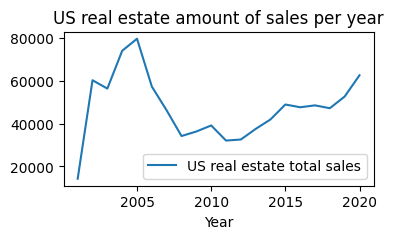

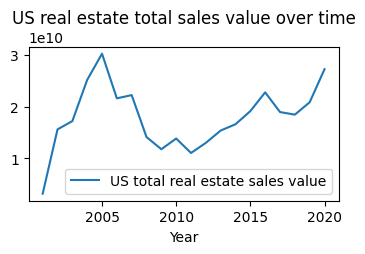

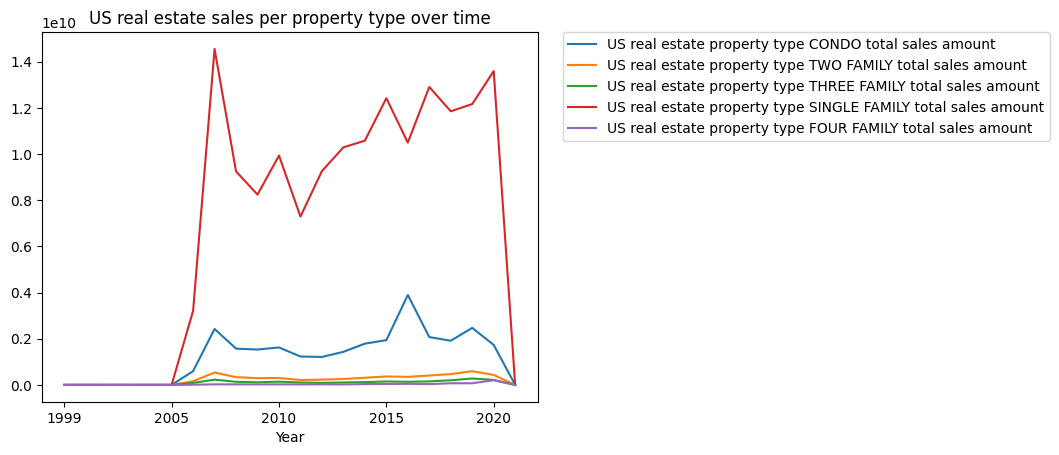

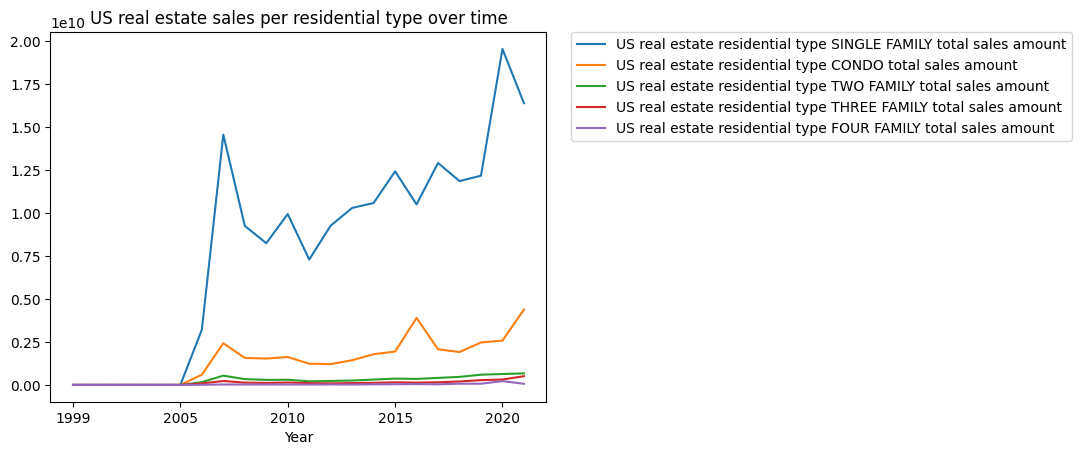

In [195]:
# Show amount of sales per year
real_estate_per_year.plot(
    x=DATE_COLUMN,
    y=real_estate_per_year.columns[1:2],
    title='US real estate amount of sales per year',
    figsize=(4, 2)
    )
plt.show()

# Show amount of money in sales per year
real_estate_per_year.plot(
    x=DATE_COLUMN,
    y=real_estate_per_year.columns[2:3],
    title='US real estate total sales value over time',
    figsize=(4, 2)
    )
plt.show()

# Show total in sales per year for each property type
property_types_annual.plot(
    x=DATE_COLUMN,
    y=property_types_annual.columns[1:],
    title='US real estate sales per property type over time',
    )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Show total in sales per year for each residential type
residential_types_annual.plot(
    x=DATE_COLUMN,
    y=residential_types_annual.columns[1:],
    title='US real estate sales per residential type over time',
    )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

### Merging all datasets by year

In [196]:
merged_df = pd.DataFrame()
# Set year column
merged_df[DATE_COLUMN] = real_estate_per_year[DATE_COLUMN].unique()
merged_df = merged_df.sort_values(by=[DATE_COLUMN]).reset_index(drop=True)
# Merge dataframes
for df in final_dataframes:
    df[DATE_COLUMN] = df[DATE_COLUMN].astype(int)
    merged_df = pd.merge(merged_df, df, on=DATE_COLUMN, how='outer')
# Show all years to see if any cell is wrong
merged_df

,Year,FGMOS transistor count,FPGA transistor count,GPU transistor count,Microprocessor transistor count,US internet percentage,US GDP,US Population,US real estate total sales,US total real estate sales value,US real estate property type CONDO total sales amount,US real estate property type TWO FAMILY total sales amount,US real estate property type THREE FAMILY total sales amount,US real estate property type SINGLE FAMILY total sales amount,US real estate property type FOUR FAMILY total sales amount,US real estate residential type SINGLE FAMILY total sales amount,US real estate residential type CONDO total sales amount,US real estate residential type TWO FAMILY total sales amount,US real estate residential type THREE FAMILY total sales amount,US real estate residential type FOUR FAMILY total sales amount
0,2000,5.368709e+08,3.500000e+08,5.100000e+07,42000000,43.079163,1.025095e+13,282162411.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,5.368709e+08,3.500000e+08,6.000000e+07,191000000,49.080832,1.058193e+13,284968955.0,14291.0,3.178363e+09,8.800000e+04,0.000000e+00,0.0,2.402711e+06,0.0,2.402711e+06,8.800000e+04,0.000000e+00,0.0,0.0
2,2002,2.147484e+09,4.300000e+08,1.070000e+08,220000000,58.785404,1.092911e+13,287625193.0,60207.0,1.560357e+10,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
3,2003,2.147484e+09,4.300000e+08,1.350000e+08,410000000,61.697117,1.145644e+13,290107933.0,56317.0,1.720434e+10,0.000000e+00,0.000000e+00,0.0,1.589000e+05,0.0,1.589000e+05,0.000000e+00,0.000000e+00,0.0,0.0
4,2004,8.589935e+09,1.000000e+09,2.220000e+08,592000000,64.758256,1.221719e+13,292805298.0,73943.0,2.516201e+10,6.329000e+05,0.000000e+00,0.0,1.949900e+06,0.0,1.949900e+06,6.329000e+05,0.000000e+00,0.0,0.0
5,2005,1.717987e+10,1.000000e+09,3.210000e+08,250000000,67.968053,1.303920e+13,295516599.0,79566.0,3.021333e+10,2.770000e+05,2.640000e+05,0.0,0.000000e+00,0.0,0.000000e+00,2.770000e+05,2.640000e+05,0.0,0.0
6,2006,3.435974e+10,1.100000e+09,6.810000e+08,1700000000,68.931193,1.381559e+13,298379912.0,57250.0,2.159822e+10,5.948589e+08,1.603019e+08,86599217.0,3.210213e+09,10182700.0,3.210213e+09,5.948589e+08,1.603019e+08,86599217.0,10182700.0
7,2007,1.280000e+11,1.100000e+09,7.540000e+08,789000000,75.000000,1.447423e+13,301231207.0,46138.0,2.222218e+10,2.423580e+09,5.385773e+08,228334313.0,1.455175e+10,25293008.0,1.455175e+10,2.423580e+09,5.385773e+08,228334313.0,25293008.0
8,2008,2.560000e+11,2.500000e+09,1.400000e+09,1900000000,74.000000,1.476986e+13,304093966.0,34195.0,1.412136e+10,1.571634e+09,3.353331e+08,134461433.0,9.249377e+09,23560218.0,9.249377e+09,1.571634e+09,3.353331e+08,134461433.0,23560218.0
9,2009,2.560000e+11,2.500000e+09,2.154000e+09,904000000,71.000000,1.447806e+13,306771529.0,36305.0,1.177615e+10,1.533074e+09,2.929898e+08,115687933.0,8.241461e+09,21736964.0,8.241461e+09,1.533074e+09,2.929898e+08,115687933.0,21736964.0


### Analizing all merged data

In [ ]:
# Exploratory analisys
numeric_df = merged_df.select_dtypes(include=['float64', 'int', 'int64'])
pp = sns.pairplot(numeric_df)